In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '/Users/zhouji/Documents/repository2')
# import TF_Kriging.Kriging_TF_V_0_1 as KrigModel

In [3]:
def constant32(k):
    return tf.constant(k,dtype = tf.float32)

In [4]:
x_1 = constant32([[0., 1.]])

x_1_tiled = tf.tile(x_1,[2,1])

In [5]:
@tf.function
def squared_euclidean_distance(x_1,x_2):
    sqd = tf.sqrt(tf.reshape(tf.reduce_sum(x_1**2,1),shape =(x_1.shape[0],1))+\
    tf.reshape(tf.reduce_sum(x_2**2,1),shape =(1,x_2.shape[0]))-\
    2*tf.tensordot(x_1,tf.transpose(x_2),1))
    return sqd

In [6]:
sq =  squared_euclidean_distance(x_1_tiled,x_1_tiled)

In [7]:
sq

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [8]:
#Cartesian distances
def cartesian_dist(x_1,x_2):
    return tf.concat([
        tf.tile(x_1[:,0] - tf.reshape(x_2[:,0],[x_2.shape[0],1]),[1,2]),
        tf.tile(x_1[:,1] - tf.reshape(x_2[:,1],[x_2.shape[0],1]),[1,2])],axis = 0) 
h_u = cartesian_dist(x_1,x_1)

In [9]:
dist_tiled = squared_euclidean_distance(x_1_tiled,x_1_tiled)

In [10]:
h_u

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.]], dtype=float32)>

In [11]:
h_v = tf.transpose(h_u)

In [12]:
a = tf.concat([tf.ones([x_1.shape[0],x_1.shape[0]]),tf.zeros([x_1.shape[0],x_1.shape[0]])],axis = 1)
b = tf.concat([tf.zeros([x_1.shape[0],x_1.shape[0]]),tf.ones([x_1.shape[0],x_1.shape[0]])],axis = 1)

perpendicularity_matrix = tf.concat([a,b],axis = 0)

In [13]:
a_T = 5
c_o_T = a_T**2/14/3

In [18]:
def cov_gradients(dist_tiled):
    C_G = (tf.math.divide_no_nan(h_u*h_v , dist_tiled**2)*\
    (-c_o_T*((-14/a_T**2)+105/4*dist_tiled/a_T**3 - 35/2 * dist_tiled**3 / a_T **5 + 21 /4 * dist_tiled**5/a_T**7)+
        c_o_T * 7 * (9 * dist_tiled ** 5 - 20 * a_T ** 2 * dist_tiled ** 3 +
                                       15 * a_T ** 4 * dist_tiled - 4 * a_T ** 5) / (2 * a_T ** 7)-
        perpendicularity_matrix * c_o_T * ((-14 / a_T ** 2) + 105 / 4 * dist_tiled / a_T ** 3 -
                                   35 / 2 * dist_tiled ** 3 / a_T ** 5 +
                                   21 / 4 * dist_tiled ** 5 / a_T ** 7))+
        1/3*tf.eye(dist_tiled.shape[0])) ## adding nugget effect
    return C_G

In [19]:
dist_tiled = dist_tiled + tf.eye(dist_tiled.shape[0])

In [20]:
C_G = cov_gradients(dist_tiled)

In [21]:
C_G

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.33333334, 0.        ],
       [0.        , 0.33333334]], dtype=float32)>

### covariance of interface points

In [29]:
#TODO : try ragged tensors to store the data
layer1 = ([[0,0],[2,0]])
layer2 = constant32([[0,2],[2,2]])

layer1 = constant32([[0,0],[2,0],[3,0],[4,0]])
layer2 = constant32([[0,2],[2,2],[3,3]])

number_of_layer = 2

layer3 = constant32([[0,4],[2,4],[3,4]])

In [30]:
layer = tf.ragged.constant([[[0,0],[2,0]],[[0,2],[2,2],[3,3]]])
layer[0].to_list()

[[0, 0], [2, 0]]

In [31]:
layer[:,:1]

<tf.RaggedTensor [[[0, 0]], [[0, 2]]]>

In [32]:
number_of_points_per_surface = np.array([layer1.shape[0],layer2.shape[0]])

In [33]:
tf.repeat(tf.stack([layer1[-1],layer2[-1]],axis = 0),repeats=number_of_points_per_surface-1,axis = 0)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[4., 0.],
       [4., 0.],
       [4., 0.],
       [3., 3.],
       [3., 3.]], dtype=float32)>

In [34]:
def set_rest_ref_matrix(number_of_points_per_surface):
    ref_layer_points = tf.repeat(tf.stack([layer1[-1],layer2[-1]],axis = 0),repeats=number_of_points_per_surface-1,axis = 0)
    rest_layer_points = tf.concat([layer1[0:-1],layer2[0:-1]],axis = 0)
    return ref_layer_points,rest_layer_points

In [35]:
ref_layer_points,rest_layer_points = set_rest_ref_matrix(number_of_points_per_surface)

In [36]:
sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)

In [37]:
def cov_interface(ref_layer_points,rest_layer_points):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)
    
    C_I = c_o_T*((1 - 7 * (sed_rest_rest / a_T) ** 2 +\
                 35 / 4 * (sed_rest_rest / a_T) ** 3 -\
                 7 / 2 * (sed_rest_rest / a_T) ** 5 +\
                 3 / 4 * (sed_rest_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_ref_rest / a_T) ** 2 +\
                  35 / 4 * (sed_ref_rest / a_T) ** 3 -\
                  7 / 2 * (sed_ref_rest / a_T) ** 5 +\
                  3 / 4 * (sed_ref_rest / a_T) ** 7) -\
                 (1 - 7 * (sed_rest_ref / a_T) ** 2 +\
                  35 / 4 * (sed_rest_ref / a_T) ** 3 -\
                  7 / 2 * (sed_rest_ref / a_T) ** 5 +\
                  3 / 4 * (sed_rest_ref / a_T) ** 7) +\
                 (1 - 7 * (sed_ref_ref / a_T) ** 2 +\
                  35 / 4 * (sed_ref_ref / a_T) ** 3 -\
                  7 / 2 * (sed_ref_ref / a_T) ** 5 +\
                  3 / 4 * (sed_ref_ref / a_T) ** 7))
    
    return C_I

In [38]:
C_I = cov_interface(ref_layer_points,rest_layer_points)

In [39]:
C_I

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1.1780878 , 0.5890439 , 0.19020197, 0.29198828, 0.0512414 ],
       [0.5890439 , 0.7078704 , 0.3539352 , 0.09175344, 0.14899345],
       [0.190202  , 0.3539352 , 0.25132185, 0.0027657 , 0.08247576],
       [0.29198828, 0.09175344, 0.0027657 , 1.0835989 , 0.40705296],
       [0.0512414 , 0.14899345, 0.08247576, 0.40705296, 0.43837753]],
      dtype=float32)>

### Covariance of interface points and gradients

In [40]:
rest_layer_points

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0., 0.],
       [2., 0.],
       [3., 0.],
       [0., 2.],
       [2., 2.]], dtype=float32)>

In [41]:
sed_dips_rest = squared_euclidean_distance(x_1_tiled,rest_layer_points)
sed_dips_ref = squared_euclidean_distance(x_1_tiled,ref_layer_points)

In [42]:
x_1_tiled

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.]], dtype=float32)>

In [43]:
rest_layer_points

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0., 0.],
       [2., 0.],
       [3., 0.],
       [0., 2.],
       [2., 2.]], dtype=float32)>

In [44]:
## Cartesian distance between dips and interface points
#Cartesian distances
def cartesian_dist_no_tile(x_1,x_2):
    return tf.concat([
        tf.transpose((x_1[:,0] - tf.reshape(x_2[:,0],[x_2.shape[0],1]))),
        tf.transpose((x_1[:,1] - tf.reshape(x_2[:,1],[x_2.shape[0],1])))],axis = 0) 

hu_rest = cartesian_dist_no_tile(x_1,rest_layer_points)
hu_ref = cartesian_dist_no_tile(x_1,ref_layer_points)

In [45]:
def cov_interface_gradients(hu_rest,hu_ref):
    C_GI = (hu_rest*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_rest / a_T ** 3 -
                                  35 / 2 * sed_dips_rest ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_rest ** 5 / a_T ** 7))-\
    hu_ref*(-c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_ref / a_T ** 3 -
                                  35 / 2 * sed_dips_ref ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_ref ** 5 / a_T ** 7)))
    return C_GI

In [46]:
C_GI = cov_interface_gradients(hu_rest,hu_ref)

In [47]:
C_IG = tf.transpose(C_GI)

In [48]:
C_GI

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0.01569869, -0.16201445, -0.07672766,  0.04351938, -0.13419376],
       [ 0.20770201,  0.0849319 ,  0.02688411, -0.18261379, -0.05984369]],
      dtype=float32)>

### 1st order drift

In [49]:
F = tf.concat([tf.eye(number_of_layer),
tf.stack([rest_layer_points[:,0] - ref_layer_points[:,0],
rest_layer_points[:,1] - ref_layer_points[:,1]])],axis = 1)

In [50]:
F_T = tf.transpose(F)

### Kriging Matrix

In [51]:
K = tf.concat([tf.concat([C_G,C_GI],axis = 1),
tf.concat([C_IG,C_I],axis = 1)],axis = 0)

In [52]:
b = tf.reshape(constant32([1,-1,1,1,0,0,0,0,0]),[7,1])

InvalidArgumentError: Input to reshape is a tensor with 9 values, but the requested shape has 7 [Op:Reshape]

In [53]:
Zero_matrix = tf.zeros([number_of_layer])

In [85]:
K

<tf.Tensor: shape=(7, 7), dtype=float32, numpy=
array([[ 0.33333334,  0.        ,  0.01569869, -0.16201445, -0.07672766,
         0.04351938, -0.13419376],
       [ 0.        ,  0.33333334,  0.20770201,  0.0849319 ,  0.02688411,
        -0.18261379, -0.05984369],
       [ 0.01569869,  0.20770201,  1.1780878 ,  0.5890439 ,  0.19020197,
         0.29198828,  0.0512414 ],
       [-0.16201445,  0.0849319 ,  0.5890439 ,  0.7078704 ,  0.3539352 ,
         0.09175344,  0.14899345],
       [-0.07672766,  0.02688411,  0.190202  ,  0.3539352 ,  0.25132185,
         0.0027657 ,  0.08247576],
       [ 0.04351938, -0.18261379,  0.29198828,  0.09175344,  0.0027657 ,
         1.0835989 ,  0.40705296],
       [-0.13419376, -0.05984369,  0.0512414 ,  0.14899345,  0.08247576,
         0.40705296,  0.43837753]], dtype=float32)>

In [41]:
w = tf.linalg.solve(K,b)

In [42]:
w

<tf.Tensor: shape=(9, 1), dtype=float32, numpy=
array([[ 3.6986923 ],
       [-1.2638927 ],
       [ 3.8836162 ],
       [ 4.778231  ],
       [-1.5646951 ],
       [ 2.7280471 ],
       [-0.74434966],
       [ 1.0092982 ],
       [-1.7616116 ]], dtype=float32)>

### Now need to find a way to interpolate

In [66]:
xx = tf.range(-.5,4.5,0.1)
yy = tf.range(-.5,4.5,0.1)
XX,YY = tf.meshgrid(xx,yy)
X = tf.transpose(tf.reshape(XX,[-1]))
Y = tf.transpose(tf.reshape(YY,[-1]))

In [67]:
grid = tf.stack([X,Y],axis = 1)

In [68]:
hu_Simpoints = cartesian_dist_no_tile(x_1,grid)

In [69]:
sed_dips_SimPoint = squared_euclidean_distance(x_1_tiled,grid)

In [70]:
sigma_0_grad = w[:x_1.shape[0]*2] * (-hu_Simpoints*(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_SimPoint / a_T ** 3 -
                               35 / 2 * sed_dips_SimPoint ** 3 / a_T ** 5 +
                               21 / 4 * sed_dips_SimPoint ** 5 / a_T ** 7)))

In [71]:
sigma_0_grad = tf.reduce_sum(sigma_0_grad,axis=0)

In [72]:
sed_rest_SimPoint = squared_euclidean_distance(rest_layer_points,grid)
sed_ref_SimPoint = squared_euclidean_distance(ref_layer_points,grid)

In [73]:
sigma_0_interf = -w[x_1.shape[0]*2:]*(c_o_T  * ((1 - 7 * (sed_rest_SimPoint / a_T) ** 2 +
             35 / 4 * (sed_rest_SimPoint / a_T) ** 3 -
             7 / 2 * (sed_rest_SimPoint / a_T) ** 5 +
             3 / 4 * (sed_rest_SimPoint / a_T) ** 7) -\
             (1 - 7 * (sed_ref_SimPoint / a_T) ** 2 +
              35 / 4 * (sed_ref_SimPoint / a_T) ** 3 -
              7 / 2 * (sed_ref_SimPoint / a_T) ** 5 +
              3 / 4 * (sed_ref_SimPoint / a_T) ** 7)))
sigma_0_interf = tf.reduce_sum(sigma_0_interf,axis = 0)

In [74]:
interpolate_result = sigma_0_grad+sigma_0_interf

In [75]:
interpolate_result.shape

TensorShape([2500])

In [76]:
intp = tf.reshape(interpolate_result,[50,50])

In [77]:
x1 = [0,0]
x2 = [2,0]
x_int1 = np.vstack([x1,x2])
# interface 2:
x3 = [0,2]
x4 = [2,2]
x_int2 = np.vstack([x3,x4])
# orientation point:
x5 = [0,1]
x = np.vstack([x1, x2, x3, x4, x5])
# orientation values
gx5 = 1.
gy5 = 1.

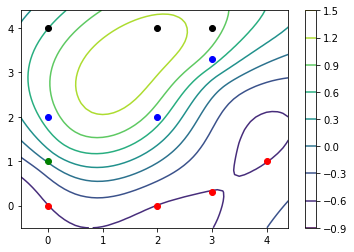

In [78]:
plt.contour(XX,YY,intp)
plt.colorbar()
plt.plot(layer1[:,0], layer1[:,1], 'ro')
plt.plot(layer2[:,0], layer2[:,1], 'bo')
plt.plot(layer3[:,0], layer3[:,1], 'ko')
plt.plot(x5[0], x5[1], 'go')